In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import random
import matplotlib.pylab as plt
from glob import glob
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import models
import keras

2021-11-24 12:44:22.200815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def _get_statistics_for_layer(model, image_bits, layer_index):
    intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.layers[layer_index].output)
        
    output = intermediate_layer_model.predict(image_bits)
    kernels_size = output.shape[3]
    
    maxes = [0]*kernels_size
    not_empty_pixels = [0]*kernels_size
    for i in range(kernels_size):
        maxes[i] = output[:,:,:,i].max()
        faltten = output[:,:,:,i].flatten()
        not_empty_pixels[i] = ((0 < faltten)*1).sum() / len(faltten)

    return [maxes, not_empty_pixels]

def get_statistics(model, image_bits, batch_size):
    conv2d_indexes = []
    for i, layer in enumerate(model.layers):
        if(isinstance(layer, Conv2D)):
            conv2d_indexes.append(i)
  
    all_statisitics = list()
    for i, layer_index in enumerate(conv2d_indexes):
        all_layer_statisitics = []
        for j, image_bits_chunk in enumerate(batch(image_bits, batch_size)):
            layer_statistics = _get_statistics_for_layer(model, image_bits_chunk, layer_index)
            
            if (j == 0):
                all_layer_statisitics = layer_statistics
            else:
                all_layer_statisitics = np.add(all_layer_statisitics, layer_statistics)
                
        all_statisitics.append(all_layer_statisitics)
    return all_statisitics

In [4]:
LABELS = ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

X = np.load('X_test.npy')

path = '6_2/epoch3.h5'
model = models.load_model('checkpoints/'+path)

size = 1000
batch_size = 50
scale = size/batch_size

image_bits = X[:size].reshape((size,299,299,1))

res = get_statistics(model, image_bits, batch_size)

2021-11-24 12:44:26.123395: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-24 12:44:26.124114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-24 12:44:26.153699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 12:44:26.154049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-11-24 12:44:26.154082: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-24 12:44:26.155590: I tensorflow/stream_executor/platform/def

2021-11-24 12:45:12.091776: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


2021-11-24 12:45:55.427487: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


18 -- Liczba nie czarnych obrazków
15 -- Liczba obrazów wypewnionych na conajmniej 5%


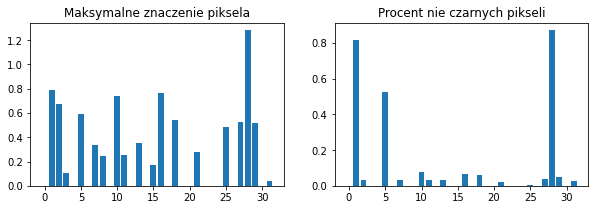

25 -- Liczba nie czarnych obrazków
15 -- Liczba obrazów wypewnionych na conajmniej 5%


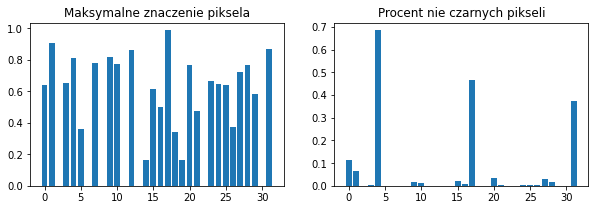

44 -- Liczba nie czarnych obrazków
21 -- Liczba obrazów wypewnionych na conajmniej 5%


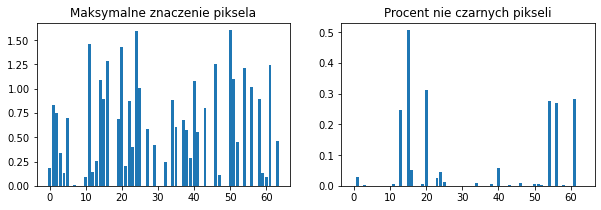

43 -- Liczba nie czarnych obrazków
25 -- Liczba obrazów wypewnionych na conajmniej 5%


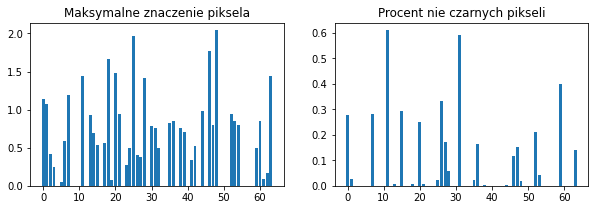

81 -- Liczba nie czarnych obrazków
33 -- Liczba obrazów wypewnionych na conajmniej 5%


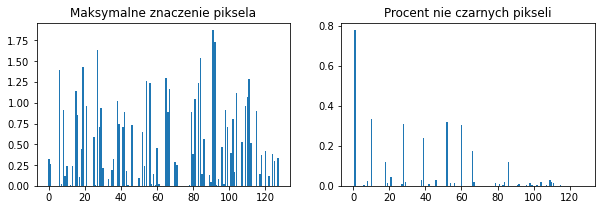

In [6]:
for layer_data in res:
    print(f'{len([a for a in layer_data[0] if a>0.05])} -- Liczba nie czarnych obrazków')
    print(f'{len([a for a in layer_data[1] if a>0.05])} -- Liczba obrazów wypewnionych na conajmniej 5%')
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.title('Maksymalne znaczenie piksela')
    plt.bar(list(range(len(layer_data[0]))), layer_data[0]/scale)
    
    plt.subplot(1,2,2)
    plt.title('Procent nie czarnych pikseli')
    plt.bar(list(range(len(layer_data[1]))), layer_data[1]/scale)
    plt.show()